In [29]:
# python 3.11
import matplotlib.image as image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy import stats

In [31]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

In [32]:
df_char_vis = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-06-30/character_visualization.csv"
)

In [33]:
df_best_chars = pd.DataFrame({
    "rank": np.linspace(1, 10, num=10),
    "char_popular": ["Wolverine", "Magneto", "Nightcrawler", "Gambit",
                     "Storm", "Colossus", "Phoenix", "Professor X", 
                     "Iceman", "Rogue"]
})

In [34]:
for character in df_best_chars["char_popular"]:
    idxs = df_char_vis["character"].str.contains(character)
    df_char_vis.loc[idxs, "character_join"] = character

In [35]:
df_best_stream = (
    pd.merge(df_char_vis, df_best_chars, left_on="character_join", right_on="char_popular")
    .groupby(["character", "char_popular", "costume", "rank", "issue"]).agg(
        speech = ("speech", sum),
        thought = ("thought", sum),
        narrative = ("narrative", sum),
        depicted = ("depicted", sum),
    )
    .query("rank <= 5")   # keep only the top 5 characters
    .query("issue < 281") 
    .reset_index()
)

In [36]:
# Costume is either 'customed' or 'casual'
df_best_stream["costume"] = np.where(df_best_stream["costume"] == "Costume", "costumed", "casual")

# char_costume contains the name of the character and the costume
df_best_stream["char_costume"] = df_best_stream["char_popular"] + " (" + df_best_stream["costume"] + ")"

# Record the categories of 'char_costume'. 
# This will be used for the order of the areas in the streamchart.
CATEGORIES = df_best_stream.sort_values(by=["rank", "char_costume"])["char_costume"].unique()
CATEGORIES = CATEGORIES[::-1]

# Put the data in long form
df_best_stream = pd.melt(
    df_best_stream,
    id_vars = ["character", "char_popular", "costume", "rank", "issue", "char_costume"],
    value_vars = ["speech", "thought", "narrative", "depicted"],
    var_name = "parameter",
    value_name = "value"
)

In [37]:
df_best_stream = df_best_stream.sort_values(by = ["char_costume", "issue"])
df_best_stream = df_best_stream.groupby(["char_costume", "issue", "parameter"]).agg(
    value = ("value", np.mean)
).reset_index()

In [42]:
plt.rcParams.update({"font.family": "sans"}) #Reem Kufi"})
PALETTE = [
    adjust_lightness("#595A52", 1.25), "#595A52",
    adjust_lightness("#8E038E", 1.2), "#8E038E",
    adjust_lightness("#13AFEF", 1.25), "#13AFEF",
    adjust_lightness("#C20008", 1.2), "#C20008",
    adjust_lightness("#FFB400", 1.25), "#FFB400"
]

GREY25 = "#404040"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY88 = "#e0e0e0"
GREY95 = "#f2f2f2"

IMAGE = image.imread("in/the-uncanny-x-men-logo-png-transparent.png")

XTICKS = [97, 125, 150, 175, 200, 225, 250, 280]


In [39]:
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

In [40]:
df_depicted = df_best_stream.query("parameter == 'depicted'")

issues = [
    df_depicted[df_depicted["char_costume"] == character]["issue"].values
    for character in CATEGORIES
]
values = [
    df_depicted[df_depicted["char_costume"] == character]["value"].values
    for character in CATEGORIES
]

grid = np.linspace(80, 300, num=1000)


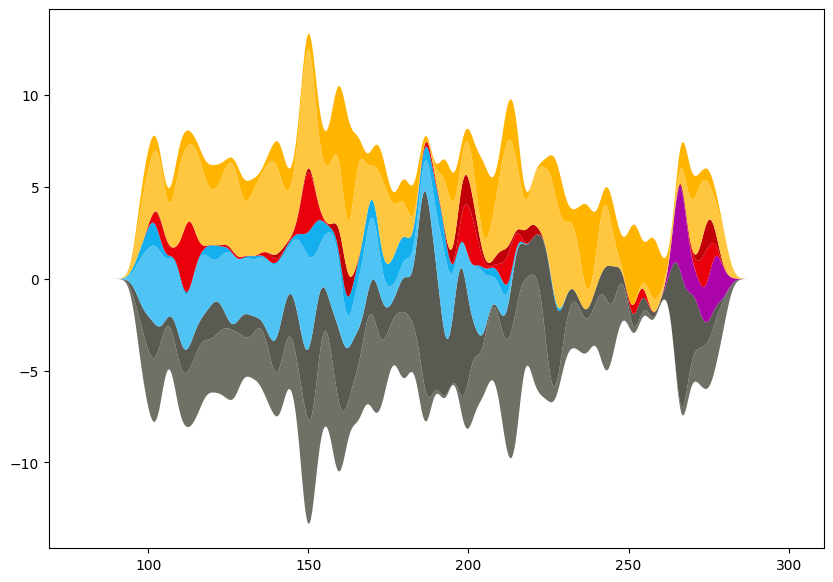

In [43]:
# Basic stacked area chart.
fig, ax = plt.subplots(figsize=(10, 7))

# sd=2 is the standard deviation of the Gaussian function.
values_smoothed = [gaussian_smooth(x, y, grid, sd=2) for x, y in zip(issues, values)]
ax.stackplot(grid, values_smoothed, colors=PALETTE, baseline="sym");

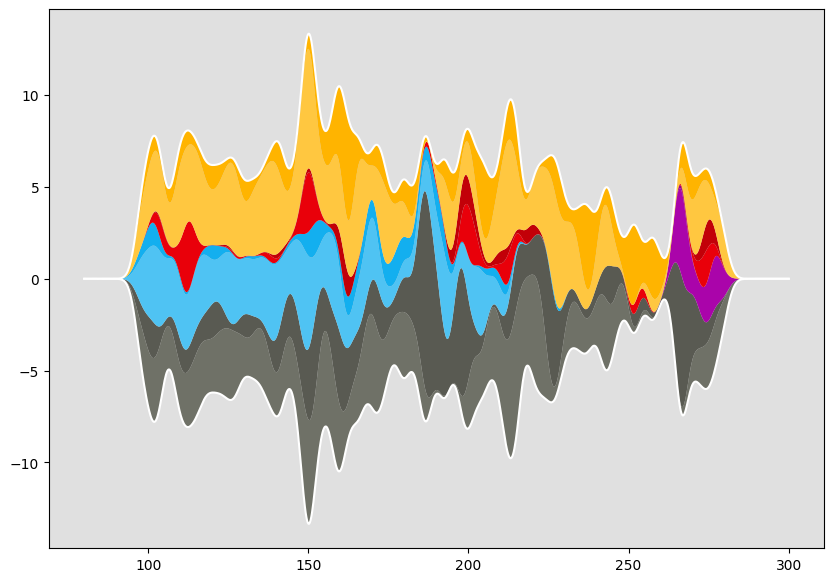

In [44]:
# Set background color
ax.set_facecolor(GREY88)

# This 'line' is the sum of values for each issue.
line = np.array(values_smoothed).sum(0)
# Two lines are added, one on top, another on the bottom.
# Both have the same height because of `baseline="sym"`
ax.plot(grid, line / 2, lw=1.5, color="white")
ax.plot(grid, -line / 2, lw=1.5, color="white")
fig

In [45]:
def streamgraph(df, parameter, ax, grid, sd=2):
    # Keep rows for the given 'parameter'
    df = df[df["parameter"] == parameter]
    
    # Same logic than above
    issues = [
        df[df["char_costume"] == character]["issue"].values
        for character in CATEGORIES
    ]
    values = [
        df[df["char_costume"] == character]["value"].values
        for character in CATEGORIES
    ]
    # Smooth values
    values_smoothed = [gaussian_smooth(x, y, grid, sd) for x, y in zip(issues, values)]
    
    # Add streamchart
    ax.stackplot(grid, values_smoothed, colors=PALETTE, baseline="sym")
    
    # Add border lines
    line = np.array(values_smoothed).sum(0)
    ax.plot(grid, line / 2, lw=1.5, color="white")
    ax.plot(grid, -line / 2, lw=1.5, color="white")
    
    # Vertical lines
    for x in XTICKS:
        ax.axvline(x, color=GREY88, ls=(0, (1, 2)), zorder=10)
    
    # Change background color and remove both axis
    ax.set_facecolor(GREY88)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
    # Also remove all spines
    ax.spines["left"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")

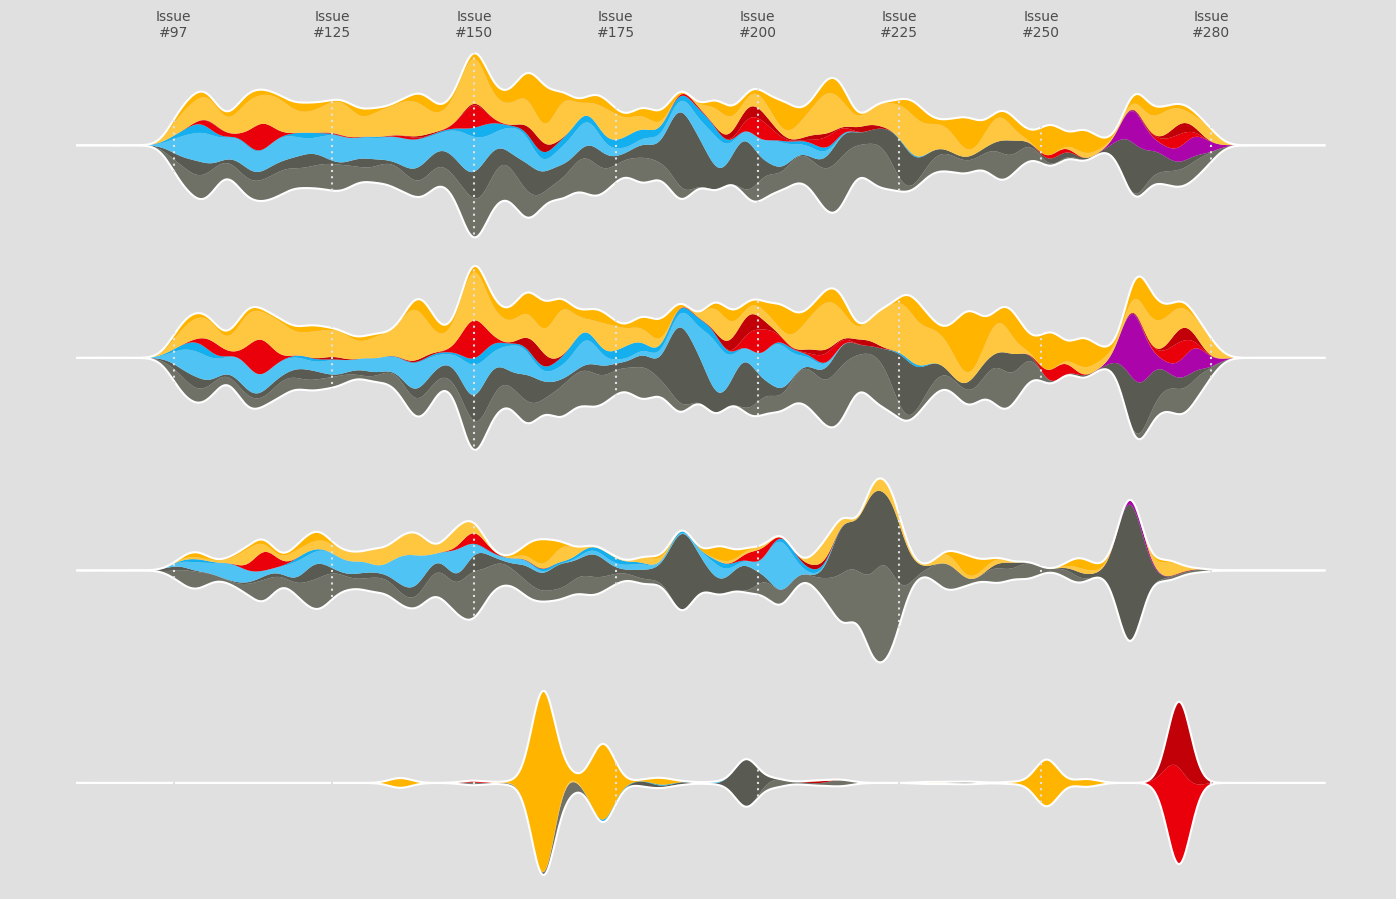

In [46]:
# Some layout stuff ----------------------------------------------
# sharex=True ensures each panel has the same horizontal range
fig, ax = plt.subplots(4, 1, figsize=(14, 10.5), sharex=True)

# Background color for the figure (not each axis)
fig.patch.set_facecolor(GREY88)

# Adjust space between panels
fig.subplots_adjust(left=0.01, bottom=0.1, right=0.99, top=0.9, hspace=0.05)

# Add streamcharts -----------------------------------------------
# This loops along the four axes in the figure.
grid = np.linspace(80, 300, num=1000)
for idx, parameter in enumerate(["depicted", "speech", "thought", "narrative"]):
    streamgraph(df_best_stream, parameter, ax[idx], grid)


# Add label for horizontal axis ----------------------------------
# Note this is only modifying the labels for `ax[0]`, the top panel.

ax[0].xaxis.set_visible(True)
ax[0].tick_params(axis="x", labeltop=True, length=0)
ax[0].set_xticks(XTICKS)
ax[0].set_xticklabels([f"Issue\n#{x}" for x in XTICKS], color=GREY30);

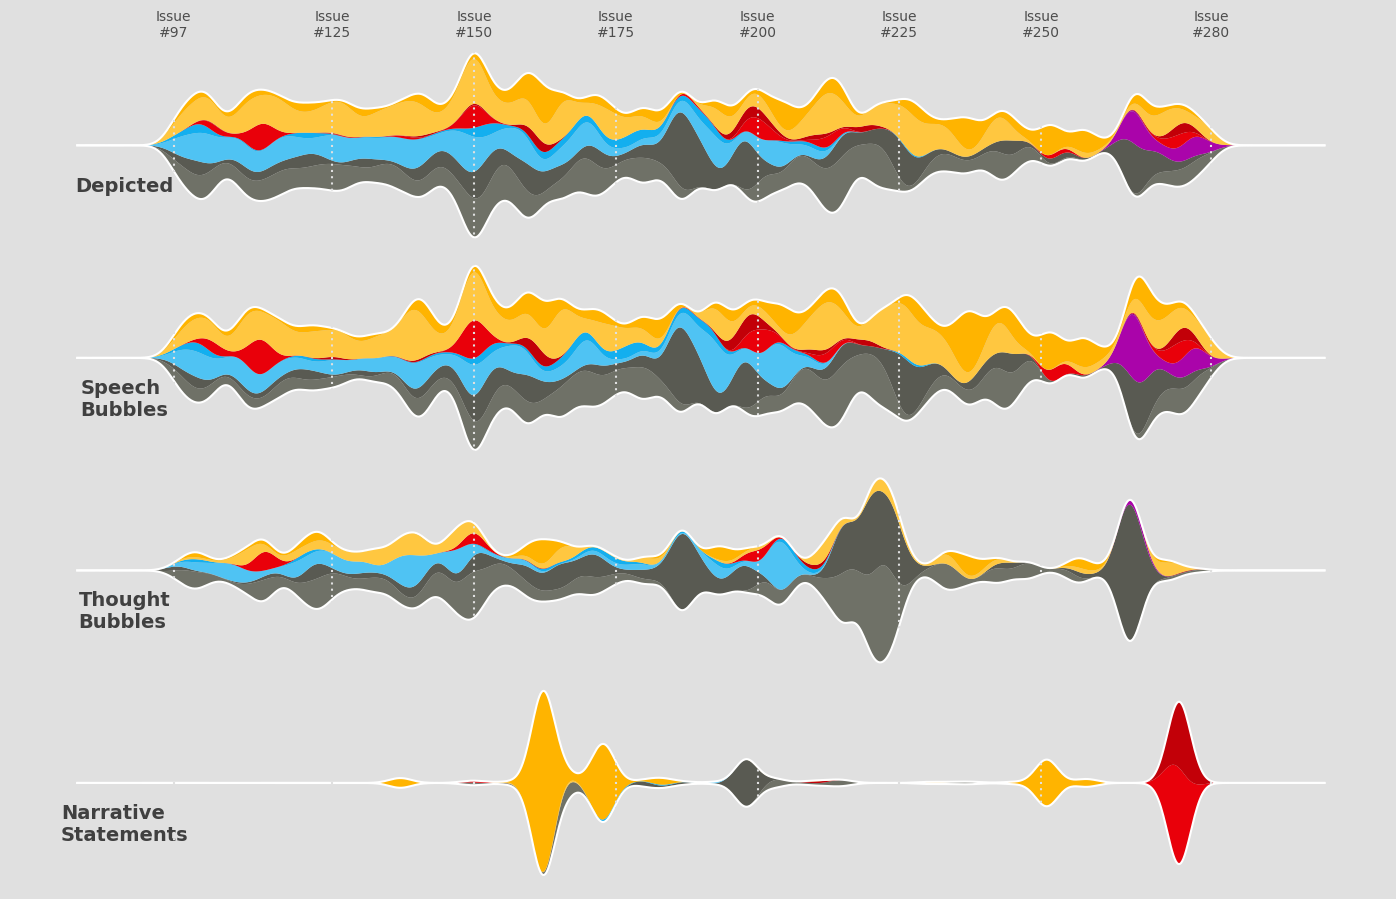

In [47]:
# Add labels for each panel axis ---------------------------------
# These labels indicate which type of appearence is represented
# on each panel.

levels = ["depicted", "speech", "thought", "narrative"]
labels = pd.DataFrame({
    "issue": [78] * 4,
    "value": [-21, -19, -14, -11],
    "parameter": pd.Categorical(levels, levels),
    "label": ["Depicted", "Speech\nBubbles", "Thought\nBubbles", "Narrative\nStatements"]
})

for idx, row in labels.iterrows():
    ax[idx].text(
        0.08, 
        0.3, 
        row["label"], 
        ha="center",
        va="center",
        ma="left",
        color=GREY25,
        size=14,
        weight=900,
        transform=ax[idx].transAxes,

    )
fig

In [50]:
# Add informative text -------------------------------------------

# The dictionaries in TEXTS contain all the information needed
# to add all the text blocks: the text, the axis where
# the text is placed, the xy location, and the color.


TEXTS = [
    {
        "text": 'Gambit was introduced for the\nfirst time in issue #266 called\n"Gambit: Out of the Frying\nPan"— nevertheless, he is the\n4th most popular X-Men\ncharacter!',
        "ax": 0,
        "x": 0.92,
        "y": 0.1,
        "color": adjust_lightness("#8E038E", 1.05)
    },
    {
        "text": 'Wolverine is the most popular\nX-Men and has a regular\npresence in the X-Men comics\nbetween 1975 and 1991',
        "ax": 0,
        "x": 0.06,
        "y": 0.80,
        "color": adjust_lightness("#FFB400", 1.1)
    },
    {
        "text": 'Storm is by far the most\nthoughtful of the five most\npopular X-Men characters,\n especially in issues #220, #223\nand #265. Storm ranks 5th.',
        "ax": 2,
        "x": 0.725,
        "y": 0.875,
        "color": adjust_lightness("#595A52", 1.01)
    },
    {
        "text": "Magneto was ranked by IGN\nas the Greatest Comic Book\nVillain of All Time. And even\nthough he only appears from\ntime to time he ranks 2nd-\n4 ranks higher than his friend\nand opponent Professor X!",
        "ax": 1,
        "x": 0.225,
        "y": 1.02,
        "color": adjust_lightness("#C20008", 1.05)
    },
    {
        "text": 'The 3rd most popular X-men\ncharacter Nightcrawler gets\ninjured during the "Mutant\nMassacre" and fell into a coma\nafter an attack from Riptide in\nissue #211.',
        "ax": 1,
        "x": 0.5,
        "y": 1.02,
        "color": adjust_lightness("#13AFEF", 1.1)
    },
    
]

for d in TEXTS:
    ax[d["ax"]].text(
        x = d["x"],
        y = d["y"],
        s = d["text"], 
        ha="center",
        va="center",
        ma="left",
        fontsize=7.5,
        color=d["color"],
        bbox=dict(
            boxstyle="round", 
            facecolor=GREY95,
            edgecolor=d["color"],
            pad=0.6
        ),
        # This transform means we pass (0, 1) coordinates to locate
        # the text block
        ktransform=ax[d["ax"]].transAxes,
        zorder=999
    )
    # This ensures the text is on top of everything
    #fig.texts.append(ax[d["ax"]].texts.pop())
fig

AttributeError: 'NoneType' object has no attribute 'dpi'

<Figure size 1400x1050 with 4 Axes>

In [49]:
# A helper function that creates each handle for the legend
def get_handle(label, color):
    line = Line2D(
        [0], 
        [0], 
        color=color, 
        label=label,
        lw=8
    )
    return line

# Create the labels
names = ["Wolverine", "Magneto", "Nightcrawler", "Gambit", "Storm"]
costumes = ["casual", "costumed"]
labels = [f"{name} ({costume})" for name in names for costume in costumes]

# And create the handles
handles = [get_handle(label, color) for label, color in zip(labels, PALETTE[::-1])]

# Now, add the legend. 
legend = fig.legend(
    handles=handles,
    bbox_to_anchor=[0.5, 0.07], # Located in the mid-bottom of the figure.
    edgecolor=GREY40,
    labelspacing=-0.1,
    loc="center", 
    ncol=5 # The 10 handles are splitted between 5 columns
)

# Change size and color of legend labels
for text in legend.get_texts():
    text.set_fontsize(8)   
    text.set_color(GREY40)

# And finally give a rounded appearence to the frame of the legend
legend.get_frame().set_boxstyle("round", rounding_size=0.4, pad=0.1)    


# Add title ------------------------------------------------------
# Note the space in the text. It is where the image will be located.
fig.text(
    0.5,
    0.95,
    "Appearance of the Five Most Popular X-Men Characters in Chris Claremont's                           Comics",
    fontsize=24,
    fontweight="bold",
    ha="center"
)


# Create annotation box to place image.
# It will be added at (0.815, 0.955) in figure coordinates.
# (0, 0) is bottom-left and (1, 1) is top-right.
ab = AnnotationBbox(
    OffsetImage(IMAGE, zoom=0.20), # Add the image with a 20% of its original size.
    (0.815, 0.955), 
    xycoords="figure fraction", 
    box_alignment=(0, 0.5),
    pad=0, 
    frameon=False
)

# Add the annotation box into the figure
fig.add_artist(ab)


# Add caption ----------------------------------------------------
# And finally, the caption that gives credit to the creator of 
# this amazing viz.
fig.text(
    0.5, 
    0.02, 
    "Visualization by Cédric Scherer  •  Data by Claremont Run Project via Malcom Barret  •  Popularity Scores by ranker.com  •  Logo by Comicraft",
    color=GREY40,
    fontsize=8,
    ha="center"

)

# Note: you can use `fig.savefig("plot.png", dpi=300)` to see this with better quality.
fig

AttributeError: 'NoneType' object has no attribute 'dpi'

<Figure size 1400x1050 with 4 Axes>